# Spongecrystal Survey

**Purpose:** Re-examine the spongecrystal structure in Qwen 3 4B's unembedding matrix
with our refined understanding of lattice-scale geometry.

**Model:** Qwen/Qwen3-4B-Instruct-2507

---

## Background

The "spongecrystal" is an anomalous structure discovered in Qwen 3 4B: thousands of tokens
(mostly unreachable Thai script) packed into a microscopic region of embedding space. Many
share *identical* embeddings ("black holes"). The structure appears to be frozen near
initialization—these tokens never received training gradients and stayed put while the
rest of the vocabulary dispersed.

## Method

1. **Load W** (unembedding matrix) from Qwen 3 4B, keep as bfloat16
2. **Find black holes** — exact duplicate rows (tokens sharing identical embeddings)
3. **Build L∞ = 1 adjacency graph** — which unique vectors are orthogonally adjacent in lattice space?
4. **Transitive closure from black holes** — flood-fill to find the connected structure
5. **Exponent analysis** — how isolated is this structure in magnitude-space?
6. **Export masks** for further analysis

## Key Findings (Spoilers)

- **13 black holes** containing **2,100 tokens** (largest: 814 tokens!)
- **36 unique vectors** in the L∞-connected core structure (2,123 tokens)
- **8 "moons"** — singletons at L∞ = 2, tantalizingly close but not touching
- The spongecrystal sits in a **void**: ±5 exponents catches only 2,212 tokens, 
  but ±13-14 exponents catches the bulk of the vocabulary
- Natural boundary at **±5 exponents** (local minimum in token accumulation rate)

In [80]:
import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from safetensors.torch import save_file
from pathlib import Path
from collections import deque
import json
from datetime import datetime

# Paths
MODEL_ID = "Qwen/Qwen3-4B-Instruct-2507"
OUTPUT_DIR = Path("../../tensors/Qwen3-4B-Instruct-2507")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Model: {MODEL_ID}")
print(f"Output: {OUTPUT_DIR}")

Model: Qwen/Qwen3-4B-Instruct-2507
Output: ../../tensors/Qwen3-4B-Instruct-2507


In [81]:
# Load just the unembedding matrix, not the whole model
# lm_head.weight is the unembedding matrix W [vocab_size, hidden_dim]

print("Loading model (this may take a moment)...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16,
    device_map="cpu"  # Keep on CPU, we're just extracting
)

W = model.lm_head.weight.detach().clone()  # [vocab_size, hidden_dim]
print(f"\nW shape: {W.shape}")
print(f"W dtype: {W.dtype}")
print(f"Vocab size: {W.shape[0]:,}")
print(f"Hidden dim: {W.shape[1]:,}")

# Free the model, we only need W
del model
torch.cuda.empty_cache() if torch.cuda.is_available() else None

Loading model (this may take a moment)...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


W shape: torch.Size([151936, 2560])
W dtype: torch.bfloat16
Vocab size: 151,936
Hidden dim: 2,560


## Step 1: Load the Model

We only need the unembedding matrix `lm_head.weight`, not the full model. Keep it in bfloat16—that's the native precision, and we need exact bit patterns for black hole detection.

In [82]:
# Step 1: Find black holes (exact duplicate rows)
# Convert to uint16 for exact bit comparison

W_bits = W.view(torch.uint16)  # [vocab_size, hidden_dim] as bit patterns

# Find unique rows and their inverse mapping
unique_rows, inverse_indices, counts = torch.unique(
    W_bits, dim=0, return_inverse=True, return_counts=True
)

n_unique = len(unique_rows)
n_duplicated = (counts > 1).sum().item()
n_tokens_in_duplicates = counts[counts > 1].sum().item()

print(f"Total tokens: {W.shape[0]:,}")
print(f"Unique vectors: {n_unique:,}")
print(f"Black holes (vectors with >1 token): {n_duplicated}")
print(f"Tokens in black holes: {n_tokens_in_duplicates:,}")

Total tokens: 151,936
Unique vectors: 149,849
Black holes (vectors with >1 token): 13
Tokens in black holes: 2,100


## Step 2: Find Black Holes

A "black hole" is a unique embedding vector occupied by multiple tokens. In bfloat16, we can find exact duplicates by comparing bit patterns (view as uint16, find unique rows).

In [83]:
# Identify which unique indices are black holes
black_hole_unique_indices = torch.where(counts > 1)[0]
print(f"Black hole unique indices: {len(black_hole_unique_indices)}")

# For each black hole, how many tokens does it contain?
print("\nBlack hole sizes:")
bh_sizes = counts[black_hole_unique_indices].sort(descending=True)
for i, (size, idx) in enumerate(zip(bh_sizes.values, bh_sizes.indices)):
    print(f"  BH#{i+1}: {size.item()} tokens")

Black hole unique indices: 13

Black hole sizes:
  BH#1: 814 tokens
  BH#2: 704 tokens
  BH#3: 306 tokens
  BH#4: 228 tokens
  BH#5: 11 tokens
  BH#6: 10 tokens
  BH#7: 6 tokens
  BH#8: 5 tokens
  BH#9: 4 tokens
  BH#10: 4 tokens
  BH#11: 3 tokens
  BH#12: 3 tokens
  BH#13: 2 tokens


In [84]:
# Get the actual embedding vectors for black hole centroids
# These are the seeds for our transitive closure

# PyTorch can't index into uint16 tensors, so convert to int32 first, index, then back
unique_rows_i32 = unique_rows.to(torch.int32)
black_hole_centroids_i32 = unique_rows_i32[black_hole_unique_indices]  # [n_black_holes, hidden_dim]
black_hole_centroids = black_hole_centroids_i32.to(torch.uint16)  # Back to uint16

print(f"Black hole centroids shape: {black_hole_centroids.shape}")

# Convert back to bfloat16 for the actual vectors
black_hole_vectors = black_hole_centroids.view(torch.bfloat16)  # [n_black_holes, hidden_dim]
print(f"Black hole vectors dtype: {black_hole_vectors.dtype}")

Black hole centroids shape: torch.Size([13, 2560])
Black hole vectors dtype: torch.bfloat16


In [85]:
# Step 2: Compute L∞ distance in lattice space between unique vectors
# L∞ = max absolute difference in any dimension, measured in ULP
#
# For efficiency, we'll work with the bit patterns directly.
# Two bfloat16 values are L∞ = 1 apart if they differ by exactly 1 in
# their uint16 representation in exactly one dimension (and 0 in all others).
#
# Actually, that's not quite right for bfloat16 due to sign bit and exponent.
# Let's use our proper ULP-based approach.

def compute_lattice_coords(W_bf16: torch.Tensor) -> torch.Tensor:
    """
    Convert bfloat16 weights to lattice coordinates.
    
    Each coordinate is the weight divided by its ULP, giving
    an integer-like value representing position on the bfloat16 lattice.
    
    Returns float32 for precision in distance calculations.
    """
    # Get bit representation
    bits = W_bf16.view(torch.uint16).to(torch.int32)
    
    # Extract exponent (bits 7-14)
    exponent = (bits >> 7) & 0xFF
    
    # Compute ULP: 2^(exponent - 134) for normal numbers
    # For subnormals (exponent = 0), effective exponent is 1
    effective_exp = torch.where(exponent == 0, torch.ones_like(exponent), exponent)
    ulp = torch.pow(2.0, (effective_exp - 134).float())
    
    # Lattice coordinate = value / ULP
    lattice_coords = W_bf16.float() / ulp
    
    return lattice_coords

# Test on a small example
test_vec = torch.tensor([0.5, -0.25, 0.125], dtype=torch.bfloat16)
test_coords = compute_lattice_coords(test_vec)
print(f"Test vector: {test_vec}")
print(f"Lattice coords: {test_coords}")

Test vector: tensor([ 0.5000, -0.2500,  0.1250], dtype=torch.bfloat16)
Lattice coords: tensor([ 128., -128.,  128.])


## Step 3: Convert to Lattice Coordinates

To measure distance in "lattice cells," we divide each weight by its ULP (Unit in Last Place). This gives us integer-like coordinates where adjacent bfloat16 values differ by 1.

**L∞ distance** = max absolute difference in any dimension. L∞ = 1 means "orthogonally adjacent" in the lattice.

In [86]:
# Convert all unique vectors to lattice coordinates
unique_vectors_bf16 = unique_rows.view(torch.bfloat16)  # [n_unique, hidden_dim]
lattice_coords = compute_lattice_coords(unique_vectors_bf16)  # [n_unique, hidden_dim]

print(f"Lattice coords shape: {lattice_coords.shape}")
print(f"Lattice coords dtype: {lattice_coords.dtype}")
print(f"\nSample lattice coords (first vector, first 10 dims):")
print(lattice_coords[0, :10])

Lattice coords shape: torch.Size([149849, 2560])
Lattice coords dtype: torch.float32

Sample lattice coords (first vector, first 10 dims):
tensor([ 243.,  147.,  223.,  154.,  141.,  148.,  128.,  140., -243., -140.])


In [87]:
# Step 3: Build adjacency graph via transitive closure from black holes
#
# Start with black hole indices, flood-fill to anything with L∞ = 1
# This is potentially expensive, so we'll be clever:
# - Only compute distances FROM the current frontier TO unexplored vectors
# - Use batched operations

def compute_linf_distance(coords_a: torch.Tensor, coords_b: torch.Tensor) -> torch.Tensor:
    """
    Compute pairwise L∞ distance between two sets of lattice coordinates.
    
    coords_a: [N, D]
    coords_b: [M, D]
    returns: [N, M] L∞ distances
    """
    # Expand for broadcasting: [N, 1, D] - [1, M, D] -> [N, M, D]
    diff = torch.abs(coords_a.unsqueeze(1) - coords_b.unsqueeze(0))
    # L∞ is max over dimensions
    return diff.max(dim=2).values

# Initialize: black hole unique indices are our seeds
in_structure = set(black_hole_unique_indices.tolist())
frontier = set(black_hole_unique_indices.tolist())
all_unique_indices = set(range(n_unique))

print(f"Starting flood fill from {len(frontier)} black hole centroids...")
iteration = 0

while frontier:
    iteration += 1
    
    # Get coordinates of frontier vectors
    frontier_list = list(frontier)
    frontier_coords = lattice_coords[frontier_list]  # [len(frontier), D]
    
    # Get coordinates of unexplored vectors
    unexplored = all_unique_indices - in_structure
    if not unexplored:
        break
    unexplored_list = list(unexplored)
    unexplored_coords = lattice_coords[unexplored_list]  # [len(unexplored), D]
    
    # Compute L∞ distances from frontier to unexplored
    # Do this in batches if needed to avoid memory issues
    BATCH_SIZE = 1000
    new_neighbors = set()
    
    for i in range(0, len(unexplored_list), BATCH_SIZE):
        batch_indices = unexplored_list[i:i+BATCH_SIZE]
        batch_coords = lattice_coords[batch_indices]
        
        # [len(frontier), len(batch)]
        distances = compute_linf_distance(frontier_coords, batch_coords)
        
        # Find any with L∞ = 1 (within floating point tolerance)
        adjacent_mask = (distances <= 1.5) & (distances >= 0.5)  # L∞ ≈ 1
        adjacent_in_batch = adjacent_mask.any(dim=0)  # Any frontier vector adjacent?
        
        for j, is_adj in enumerate(adjacent_in_batch):
            if is_adj:
                new_neighbors.add(batch_indices[j])
    
    print(f"  Iteration {iteration}: frontier={len(frontier)}, found {len(new_neighbors)} new neighbors")
    
    # Update for next iteration
    in_structure.update(new_neighbors)
    frontier = new_neighbors

print(f"\nFlood fill complete!")
print(f"Total unique vectors in structure: {len(in_structure)}")

Starting flood fill from 13 black hole centroids...
  Iteration 1: frontier=13, found 19 new neighbors
  Iteration 2: frontier=19, found 4 new neighbors
  Iteration 3: frontier=4, found 0 new neighbors

Flood fill complete!
Total unique vectors in structure: 36


## Step 4: Flood Fill to Find Connected Structure

Starting from black hole centroids, we flood-fill along L∞ = 1 edges. Any vector reachable through a chain of orthogonal adjacencies is part of the "core spongecrystal."

In [88]:
# Convert back to token indices
# inverse_indices tells us which unique index each token maps to

structure_unique_indices = torch.tensor(list(in_structure))

# Create mask: is each token in the structure?
spongecrystal_mask = torch.zeros(W.shape[0], dtype=torch.bool)
for unique_idx in in_structure:
    token_mask = (inverse_indices == unique_idx)
    spongecrystal_mask |= token_mask

# Create black hole mask
black_hole_mask = torch.zeros(W.shape[0], dtype=torch.bool)
for unique_idx in black_hole_unique_indices.tolist():
    token_mask = (inverse_indices == unique_idx)
    black_hole_mask |= token_mask

print(f"Spongecrystal tokens: {spongecrystal_mask.sum().item():,}")
print(f"Black hole tokens: {black_hole_mask.sum().item():,}")
print(f"Singleton tokens in structure: {spongecrystal_mask.sum().item() - black_hole_mask.sum().item()}")

Spongecrystal tokens: 2,123
Black hole tokens: 2,100
Singleton tokens in structure: 23


In [89]:
# Sanity check: look for nearby vectors NOT in the structure
# These would be isolated singletons floating near the spongecrystal

outside_structure = all_unique_indices - in_structure
print(f"Unique vectors outside structure: {len(outside_structure):,}")

if outside_structure and in_structure:
    outside_list = list(outside_structure)
    inside_list = list(in_structure)
    
    outside_coords = lattice_coords[outside_list]
    inside_coords = lattice_coords[inside_list]
    
    # For each outside vector, find min L∞ to any inside vector
    # Do in batches
    min_distances = []
    BATCH_SIZE = 500
    
    for i in range(0, len(outside_list), BATCH_SIZE):
        batch_coords = outside_coords[i:i+BATCH_SIZE]
        distances = compute_linf_distance(batch_coords, inside_coords)  # [batch, inside]
        min_dist = distances.min(dim=1).values
        min_distances.append(min_dist)
    
    min_distances = torch.cat(min_distances)
    
    # How many are "close" (L∞ ≤ 5) but not connected?
    close_but_disconnected = (min_distances <= 5).sum().item()
    very_close = (min_distances <= 2).sum().item()
    
    print(f"\nNearby but disconnected (L∞ ≤ 5): {close_but_disconnected}")
    print(f"Very close but disconnected (L∞ ≤ 2): {very_close}")
    print(f"\nMin distance distribution of outside vectors:")
    print(f"  Min: {min_distances.min().item():.1f}")
    print(f"  Median: {min_distances.median().item():.1f}")
    print(f"  Max: {min_distances.max().item():.1f}")

Unique vectors outside structure: 149,813

Nearby but disconnected (L∞ ≤ 5): 10
Very close but disconnected (L∞ ≤ 2): 8

Min distance distribution of outside vectors:
  Min: 2.0
  Median: 505.0
  Max: 510.0


## Step 5: The Moons

Some vectors are *almost* touching the structure but not quite—L∞ = 2, meaning one dimension is 2 lattice cells away instead of 1. We call these "moons." They're interesting because they might be fellow frozen tokens that drifted just slightly too far to maintain contact.

In [90]:
# Investigate the "moons" — vectors very close but not connected
# L∞ ≤ 2 means at most 2 lattice cells away in any dimension

moon_mask = min_distances <= 2
moon_indices = [outside_list[i] for i, is_moon in enumerate(moon_mask) if is_moon]
moon_distances = min_distances[moon_mask]

print(f"Found {len(moon_indices)} moons (L∞ ≤ 2 but not connected)")
print(f"\nMoon distances: {moon_distances.tolist()}")

# For each moon, find its nearest neighbor in the structure and examine the gap
print("\n" + "="*60)
print("MOON ANALYSIS")
print("="*60)

for i, moon_idx in enumerate(moon_indices):
    moon_coord = lattice_coords[moon_idx]  # [hidden_dim]
    
    # Find nearest structure member
    distances_to_structure = torch.abs(moon_coord.unsqueeze(0) - inside_coords).max(dim=1).values
    nearest_idx_in_list = distances_to_structure.argmin().item()
    nearest_structure_idx = inside_list[nearest_idx_in_list]
    nearest_coord = inside_coords[nearest_idx_in_list]
    
    # Dimensional breakdown
    dim_distances = torch.abs(moon_coord - nearest_coord)
    max_gap = dim_distances.max().item()
    gap_dims = torch.where(dim_distances > 0.5)[0]  # Dimensions with any gap
    big_gap_dims = torch.where(dim_distances > 1.5)[0]  # Dimensions with gap > 1
    
    # Which tokens map to this moon?
    moon_tokens = torch.where(inverse_indices == moon_idx)[0]
    
    print(f"\nMoon #{i+1} (unique idx {moon_idx}):")
    print(f"  L∞ distance to structure: {max_gap:.2f}")
    print(f"  Tokens at this location: {len(moon_tokens)}")
    print(f"  Dimensions with any gap: {len(gap_dims)}")
    print(f"  Dimensions with gap > 1: {len(big_gap_dims)} → {big_gap_dims.tolist()[:10]}{'...' if len(big_gap_dims) > 10 else ''}")

Found 8 moons (L∞ ≤ 2 but not connected)

Moon distances: [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]

MOON ANALYSIS

Moon #1 (unique idx 12916):
  L∞ distance to structure: 2.00
  Tokens at this location: 1
  Dimensions with any gap: 2
  Dimensions with gap > 1: 2 → [1008, 1382]

Moon #2 (unique idx 12931):
  L∞ distance to structure: 2.00
  Tokens at this location: 1
  Dimensions with any gap: 3
  Dimensions with gap > 1: 1 → [1008]

Moon #3 (unique idx 12932):
  L∞ distance to structure: 2.00
  Tokens at this location: 1
  Dimensions with any gap: 8
  Dimensions with gap > 1: 1 → [322]

Moon #4 (unique idx 12933):
  L∞ distance to structure: 2.00
  Tokens at this location: 1
  Dimensions with any gap: 2
  Dimensions with gap > 1: 1 → [1008]

Moon #5 (unique idx 12934):
  L∞ distance to structure: 2.00
  Tokens at this location: 1
  Dimensions with any gap: 8
  Dimensions with gap > 1: 1 → [1008]

Moon #6 (unique idx 12948):
  L∞ distance to structure: 2.00
  Tokens at this location: 1


In [91]:
# Do ANY other tokens share the spongecrystal's exponent signature?
#
# For each dimension, extract the exponent (bits 7-14 of bfloat16).
# If a token has the same exponent in ALL dimensions as the spongecrystal,
# it's on the same lattice. Otherwise, it's on a different scale entirely.

def extract_exponents(W_bf16: torch.Tensor) -> torch.Tensor:
    """Extract exponent bits from bfloat16 tensor. Returns uint8 [N, D]."""
    bits = W_bf16.view(torch.uint16).to(torch.int32)
    exponents = ((bits >> 7) & 0xFF).to(torch.uint8)
    return exponents

# Get exponents for everything
W_exponents = extract_exponents(W)  # [vocab_size, hidden_dim]
print(f"Exponent tensor shape: {W_exponents.shape}")

# Get the spongecrystal's exponent signature
# Since all spongecrystal members should have ~same exponents (they're tiny), 
# let's use the first black hole centroid as reference
sponge_indices = torch.where(spongecrystal_mask)[0]
reference_idx = sponge_indices[0].item()
sponge_exponents = W_exponents[reference_idx]  # [hidden_dim]

print(f"\nSpongecrystal reference exponent signature (first 20 dims):")
print(sponge_exponents[:20].tolist())

# How many unique exponent values does the spongecrystal use?
unique_exps = torch.unique(sponge_exponents)
print(f"\nUnique exponents in spongecrystal signature: {len(unique_exps)}")
print(f"Exponent values: {unique_exps.tolist()}")

Exponent tensor shape: torch.Size([151936, 2560])

Spongecrystal reference exponent signature (first 20 dims):
[119, 120, 120, 122, 121, 120, 119, 120, 121, 122, 120, 118, 121, 122, 121, 119, 117, 119, 122, 120]

Unique exponents in spongecrystal signature: 16
Exponent values: [107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123]


## Step 6: Exponent Signature Analysis

L∞ distance in lattice coordinates only makes sense *within* an exponent. Different exponents mean different lattice scales entirely. Here we ask: does the spongecrystal share its exponent signature (per-dimension exponent values) with anyone else?

This reveals how isolated the spongecrystal is in magnitude-space—is it alone in its region, or are there neighbors at different lattice scales?

In [92]:
# Now the big question: how many tokens match this exponent signature EXACTLY?

# Compare every token's exponents to the spongecrystal reference
matches_per_dim = (W_exponents == sponge_exponents.unsqueeze(0))  # [vocab_size, hidden_dim]
full_matches = matches_per_dim.all(dim=1)  # [vocab_size] - True if ALL dims match

n_full_matches = full_matches.sum().item()
n_sponge = spongecrystal_mask.sum().item()

print(f"Tokens with EXACT exponent signature match: {n_full_matches}")
print(f"Spongecrystal tokens: {n_sponge}")
print(f"Non-spongecrystal tokens with same signature: {n_full_matches - n_sponge}")

if n_full_matches == n_sponge:
    print(f"\n✨ The spongecrystal is ALONE on its lattice!")
    print(f"   No other tokens share the same exponent in all {W.shape[1]} dimensions.")
    print(f"   The moons must be on adjacent but different lattices.")
else:
    extra = n_full_matches - n_sponge
    print(f"\n🔍 Found {extra} additional tokens on the same lattice!")
    print(f"   These are candidates for extended structure.")

Tokens with EXACT exponent signature match: 2139
Spongecrystal tokens: 2123
Non-spongecrystal tokens with same signature: 16

🔍 Found 16 additional tokens on the same lattice!
   These are candidates for extended structure.


In [93]:
# How close is the spongecrystal to the "middle" of its exponent in each dimension?
#
# For bfloat16: 1 sign bit, 8 exponent bits, 7 mantissa bits
# Within an exponent, mantissa ranges from 0 to 127 (128 values)
# "Middle" of the exponent = mantissa around 64
#
# Distance to exponent boundary:
#   - mantissa 0 → at the LOW edge, 0 steps to lower exponent
#   - mantissa 127 → at the HIGH edge, 0 steps to upper exponent
#   - mantissa 64 → middle, 64 steps to either edge

def extract_mantissa(W_bf16: torch.Tensor) -> torch.Tensor:
    """Extract 7-bit mantissa from bfloat16 tensor. Returns uint8 [N, D]."""
    bits = W_bf16.view(torch.uint16).to(torch.int32)
    mantissa = (bits & 0x7F).to(torch.uint8)  # Bottom 7 bits
    return mantissa

# Get mantissas for spongecrystal tokens
sponge_W = W[spongecrystal_mask]  # [n_sponge, hidden_dim]
sponge_mantissa = extract_mantissa(sponge_W)  # [n_sponge, hidden_dim]

print(f"Spongecrystal mantissa shape: {sponge_mantissa.shape}")

# For each dimension, what's the range of mantissa values?
mantissa_min = sponge_mantissa.min(dim=0).values  # [hidden_dim]
mantissa_max = sponge_mantissa.max(dim=0).values  # [hidden_dim]
mantissa_span = mantissa_max - mantissa_min

print(f"\nMantissa statistics across spongecrystal (per dimension):")
print(f"  Min of mins: {mantissa_min.min().item()}")
print(f"  Max of maxs: {mantissa_max.max().item()}")
print(f"  Mean span: {mantissa_span.float().mean().item():.1f}")
print(f"  Max span: {mantissa_span.max().item()}")

# Distance to nearest exponent boundary
# Lower boundary at mantissa=0, upper at mantissa=127
dist_to_lower = mantissa_min  # How far from 0?
dist_to_upper = 127 - mantissa_max  # How far from 127?
dist_to_nearest = torch.minimum(dist_to_lower, dist_to_upper)

print(f"\nDistance to nearest exponent boundary (per dimension):")
print(f"  Min distance: {dist_to_nearest.min().item()} (most precarious)")
print(f"  Mean distance: {dist_to_nearest.float().mean().item():.1f}")
print(f"  Max distance: {dist_to_nearest.max().item()} (most centered)")

# How many dimensions are "close to the edge" (< 10 steps)?
close_to_edge = (dist_to_nearest < 10).sum().item()
very_close = (dist_to_nearest < 5).sum().item()
print(f"\nDimensions within 10 steps of exponent boundary: {close_to_edge}")
print(f"Dimensions within 5 steps of exponent boundary: {very_close}")

Spongecrystal mantissa shape: torch.Size([2123, 2560])

Mantissa statistics across spongecrystal (per dimension):
  Min of mins: 0
  Max of maxs: 127
  Mean span: 0.0
  Max span: 12

Distance to nearest exponent boundary (per dimension):
  Min distance: 0 (most precarious)
  Mean distance: 30.9
  Max distance: 63 (most centered)

Dimensions within 10 steps of exponent boundary: 438
Dimensions within 5 steps of exponent boundary: 208


In [94]:
# Relax the exponent matching: allow ±N exponents per dimension
# 
# First, let's see how many tokens are "close" with different tolerances

sponge_exp_i32 = sponge_exponents.to(torch.int32)  # [hidden_dim]
W_exp_i32 = W_exponents.to(torch.int32)  # [vocab_size, hidden_dim]

for tolerance in [0, 1, 2, 3]:
    # How many dimensions match within ±tolerance for each token?
    exp_diff = torch.abs(W_exp_i32 - sponge_exp_i32.unsqueeze(0))  # [vocab_size, hidden_dim]
    within_tolerance = (exp_diff <= tolerance)  # [vocab_size, hidden_dim]
    dims_matching = within_tolerance.sum(dim=1)  # [vocab_size]
    
    # How many tokens match ALL dimensions?
    full_match = (dims_matching == W.shape[1]).sum().item()
    
    # How many match all but 1? All but 5? All but 10?
    almost_1 = (dims_matching >= W.shape[1] - 1).sum().item()
    almost_5 = (dims_matching >= W.shape[1] - 5).sum().item()
    almost_10 = (dims_matching >= W.shape[1] - 10).sum().item()
    
    print(f"Tolerance ±{tolerance} exponents:")
    print(f"  Full match (all {W.shape[1]} dims): {full_match:,}")
    print(f"  All but 1 dim: {almost_1:,}")
    print(f"  All but 5 dims: {almost_5:,}")
    print(f"  All but 10 dims: {almost_10:,}")
    print()

Tolerance ±0 exponents:
  Full match (all 2560 dims): 2,139
  All but 1 dim: 2,145
  All but 5 dims: 2,166
  All but 10 dims: 2,181

Tolerance ±1 exponents:
  Full match (all 2560 dims): 2,177
  All but 1 dim: 2,194
  All but 5 dims: 2,209
  All but 10 dims: 2,212

Tolerance ±2 exponents:
  Full match (all 2560 dims): 2,195
  All but 1 dim: 2,203
  All but 5 dims: 2,212
  All but 10 dims: 2,214

Tolerance ±3 exponents:
  Full match (all 2560 dims): 2,205
  All but 1 dim: 2,208
  All but 5 dims: 2,213
  All but 10 dims: 2,219



Exponent tolerance vs token count (full dimensional match):
  ±Exp     Tokens      Delta
----------------------------
     0      2,139      2,139
     1      2,177         38
     2      2,195         18
     3      2,205         10
     4      2,211          6
     5      2,212          1
     6      2,215          3
     7      2,224          9
     8      2,237         13
     9      2,283         46
    10      2,486        203
    11      3,640      1,154
    12     10,276      6,636
    13     40,967     30,691
    14    110,623     69,656
    15    149,302     38,679
    16    151,240      1,938
    17    151,598        358
    18    151,765        167
    19    151,855         90
    20    151,888         33


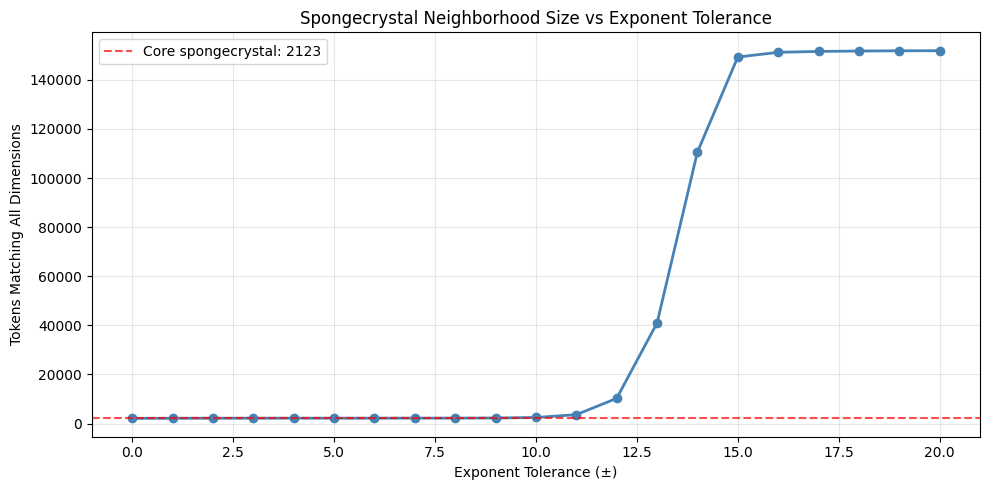

In [95]:
# Push further: where does the population explode?
# Let's go from ±0 to ±20 and look for a knee

tolerances = list(range(0, 21))
full_match_counts = []

for tolerance in tolerances:
    exp_diff = torch.abs(W_exp_i32 - sponge_exp_i32.unsqueeze(0))
    within_tolerance = (exp_diff <= tolerance)
    dims_matching = within_tolerance.sum(dim=1)
    full_match = (dims_matching == W.shape[1]).sum().item()
    full_match_counts.append(full_match)
    
# Print as table
print("Exponent tolerance vs token count (full dimensional match):")
print(f"{'±Exp':>6} {'Tokens':>10} {'Delta':>10}")
print("-" * 28)
prev = 0
for tol, count in zip(tolerances, full_match_counts):
    delta = count - prev
    print(f"{tol:>6} {count:>10,} {delta:>10,}")
    prev = count

# Plot it
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(tolerances, full_match_counts, 'o-', color='steelblue', linewidth=2, markersize=6)
ax.set_xlabel('Exponent Tolerance (±)')
ax.set_ylabel('Tokens Matching All Dimensions')
ax.set_title('Spongecrystal Neighborhood Size vs Exponent Tolerance')
ax.axhline(y=2123, color='red', linestyle='--', alpha=0.7, label=f'Core spongecrystal: {2123}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 7: Finding the Natural Boundary

By relaxing the exponent tolerance (±1, ±2, ..., ±20), we can see where the token population explodes. The **local minimum in the delta** (tokens added per exponent step) marks the natural boundary between "spongecrystal neighborhood" and "the void."

This turns out to be **±5 exponents**—beyond that, we start catching the trained vocabulary.

## Step 8: Export

We save three masks at different granularities:

1. **black_hole_mask** — tokens sharing exact embedding with at least one other (2,100 tokens)
2. **spongecrystal_mask** — L∞ = 1 transitive closure from black holes (2,123 tokens, 36 unique vectors)
3. **neighborhood_mask** — everything within ±5 exponents (2,212 tokens, the defensible boundary)

Plus the full W matrix as uint16 (preserving exact bfloat16 bit patterns) and metadata.

In [96]:
# Create neighborhood mask (±5 exponents, our defensible boundary)
NEIGHBORHOOD_TOLERANCE = 5

exp_diff = torch.abs(W_exp_i32 - sponge_exp_i32.unsqueeze(0))
within_tolerance = (exp_diff <= NEIGHBORHOOD_TOLERANCE)
dims_matching = within_tolerance.sum(dim=1)
neighborhood_mask = (dims_matching == W.shape[1])

print(f"Neighborhood mask (±{NEIGHBORHOOD_TOLERANCE} exponents): {neighborhood_mask.sum().item():,} tokens")
print(f"Core spongecrystal (L∞ connected): {spongecrystal_mask.sum().item():,} tokens")
print(f"Black holes: {black_hole_mask.sum().item():,} tokens")

# Save everything
W_uint16 = W.view(torch.uint16)

save_file(
    {"W": W_uint16},
    OUTPUT_DIR / "W_unembed.safetensors"
)
print(f"\nSaved W_unembed.safetensors")

save_file(
    {
        "black_hole_mask": black_hole_mask,
        "spongecrystal_mask": spongecrystal_mask,  # L∞ = 1 transitive closure
        "neighborhood_mask": neighborhood_mask,     # ±5 exponents
    },
    OUTPUT_DIR / "masks.safetensors"
)
print(f"Saved masks.safetensors")

# Metadata
metadata = {
    "model_id": MODEL_ID,
    "extraction_date": datetime.now().isoformat(),
    "vocab_size": W.shape[0],
    "hidden_dim": W.shape[1],
    "n_unique_vectors": n_unique,
    "n_black_holes": len(black_hole_unique_indices),
    "n_tokens_in_black_holes": black_hole_mask.sum().item(),
    "n_spongecrystal_tokens": spongecrystal_mask.sum().item(),
    "n_unique_in_core_structure": len(in_structure),
    "n_neighborhood_tokens": neighborhood_mask.sum().item(),
    "neighborhood_exponent_tolerance": NEIGHBORHOOD_TOLERANCE,
    "flood_fill_iterations": iteration,
}

with open(OUTPUT_DIR / "metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)
print(f"Saved metadata.json")

print(f"\n" + "="*60)
print("SUMMARY")
print("="*60)
for k, v in metadata.items():
    print(f"  {k}: {v}")

Neighborhood mask (±5 exponents): 2,212 tokens
Core spongecrystal (L∞ connected): 2,123 tokens
Black holes: 2,100 tokens

Saved W_unembed.safetensors
Saved masks.safetensors
Saved metadata.json

SUMMARY
  model_id: Qwen/Qwen3-4B-Instruct-2507
  extraction_date: 2025-11-26T17:01:34.320589
  vocab_size: 151936
  hidden_dim: 2560
  n_unique_vectors: 149849
  n_black_holes: 13
  n_tokens_in_black_holes: 2100
  n_spongecrystal_tokens: 2123
  n_unique_in_core_structure: 36
  n_neighborhood_tokens: 2212
  neighborhood_exponent_tolerance: 5
  flood_fill_iterations: 3


## Next Steps

With the masks saved, we can now:

1. **Build the adjacency graph** — 36 unique vectors, edges where L∞ = 1. Visualize the topology.
2. **Degree distribution** — is it a clique? A tree? A hairball?
3. **Examine the moons** — what tokens are they? Why did they drift?
4. **Linguistic analysis** — are the neighborhood extras also Thai? Or something different?
5. **Compare to old lore** — our numbers differ slightly from the lore card. Update it.